# Семинар 3. Denoising Diffusion Probabilistic Models

*Автор*: Александр Колесов

## 1. Другой взгляд на модель вариационного кодировщика



Представим, что у нас есть набор данных, состоящий из двух классов:

- кошечки;
- собачки.

В мире машинного обучения модели делятся на два типа:

- дискриминативные;
- генеративные.

Посмотрим на примере кошечек и собачек, какие задачи решают данные модели:

- Что решают дискриминативные модели?
- Что решают модели генеративные?


Определив основную задачу генеративных моделей, логично задать себе вопрос: «А как оценивать вероятность объектов из обучающей выборки?»


![title](https://learnopencv.com/wp-content/uploads/2020/10/gen_disc_model-1.jpg)

- Принцип максимума правдоподобия:

Когда мы хотим обучить генеративную модель $p(x|\theta)$, то первая попытка сделать это лежит в основе  решения так называемой $\textbf{MLE-problem}$ или задачи максимизации правдоподобия модели за счет подбора ее параметров:

$$\theta = \arg\max_{\theta} \log p(X|\theta) = \{ X = \{ x_{i}\}_{i=1}^{n}\}=  \arg\max_{\theta} \sum_{i=1}^{n} \log p(x_{i}|\theta).$$


**Вопрос на подумать**: Почему такой подход нас не устраивает?

-  Латентное пространство:

Прежде чем мы перейдем к другому способу оценивания правдоподобия данных, вспомним суть латентных представлений, основная интуиция которых представлена на картинке ниже:

![title](https://github.com/r-isachenko/2022-2023-DGM-MIPT-course/blob/main/seminars/seminar3/pics/lvm_diagram.png?raw=true)


- Модели вариационного кодировщика:

Другая попытка оценить правдоподобие — ввести латентные переменные и рассмотреть модель VAE.
При работе с вариационным автокодировщиком у нас нет доступа к честному значению логарифма правдоподобия, поэтому мы оптимизируем соответствующую нижнюю оценку, которую называем $\textbf{ELBO}:$


$$ \log p(x|\theta) \geq \mathcal{L}(\theta,q) = \int_{Z}q(z|x, \phi)\log\frac{p(x,z|\theta)}{q(z|x,\phi)} dz.$$

- Расширение латентного пространства:

Мы знаем, что вариационный автокодировщик имеет ровно одно латентное пространство. То есть мы энкодером пришли в латентное пространство и сразу же оттуда уходим при помощи декодера, при этом никак больше латентное пространство не исследуем.

Однако давайте попробуем расширить количество латентных пространств за счет введения $T$ последовательных латентных пространств с соответствующими декомпозициями $f_{i}$. То есть мы энкодером переходим в латентное пространство и делаем в нем некоторое количество шагов.

   

## 2.  Иерархические модели вариационного кодировщика

Модель вариационного кодировщика, в которой используется более одного латентного представления, называется **иерархической моделью VAE**. Давайте более детально разберем эту модель.



Для упрощения введем следующие обозначения:

- $ x = x_0 $
- $ z_1 = x_1 $
- $ z_2 = x_2 $
- $ z_T = x_T $

После введения более удобной нотации для $ T $-мерных векторов нужно определить функции преобразования $ f_i $ между скрытыми состояниями. Безусловно, для этого можно рассматривать нейронные сети, однако пока не стоит усложнять себе жизнь.

**Предположение:** пусть эти функции $ f_i $ являются **необучаемыми** определенными преобразованиями. Поскольку мы хотим добавить некоторую стохастичность в нашу модель (ведь в модели VAE энкодер стохастический, у нас распределение), можно рассматривать фиксированные распределения как такие преобразования:

$ q(x_t | x_{t-1}) = \mathcal{N}(x_t | x_{t-1}, \beta I). $

Теперь наш метод напоминает **броуновское движение** или **случайные движения**.

Однако если мы будем обучать средние значения таких преобразований (нормальных распределений), то получим метод, который называется **иерархическим VAE**. Пожалуйста, ознакомьтесь с этим [блогом](https://jmtomczak.github.io/blog/9/9_hierarchical_lvm_p1.html) для лучшего понимания концепта.

Благодаря этому концепту мы понимаем, что можно целиком рассматривать скрытые пространства $ Z = \{x_1, \ldots, x_T\} $, и тогда соответствующая формула **ELBO** перепишется так:

$ \log p(x | \theta) \geq \mathcal{L}(\theta, q) = \int_Z q(x_1, \ldots, x_T | x_0, \phi) \log \frac{p(x_0, x_1, \ldots, x_T | \theta)}{q(x_1, \ldots, x_T | x_0, \phi)} dx_{1:T} .$

Заметьте, что сейчас формула та же самая, что и ранее, только вместо одной латентной компоненты  $Z$ у нас $\{x_1, \ldots, x_T\}.$

## 3. Гауссовский диффузионный процесс

Поскольку качество генерации иерархической модели вариационного кодировщика лучше обычного, возникает вопрос.  

**Вопрос на подумать:** какой напрашивается вывод по количеству латентных представлений?

Тогда мы понимаем, что чем больше латентных пространств мы рассматриваем, тем лучше и лучше качество модели.

**А если таких латентных представлений взять очень много, то что получится?**

Давайте чуть-чуть подправим нашу переходную плотность иерархической модели вариационного кодировщика:

$$ q(x_t | x_{t-1}) = \mathcal{N}(x_t | x_{t-1}, \beta I) \to  q(x_t | x_{t-1}) = \mathcal{N}(x_t | \sqrt{1-\beta}x_{t-1}, \beta I).$$

Тогда получается, что такая переходная плотность определяет марковский процесс (где настоящее $x_{t}$ зависит только от прошлого $x_{t-1}$):

 $$  x_t = \sqrt{1 - \beta} x_{t-1} + \sqrt{\beta} \epsilon ,$$

где  $ \epsilon $ обычно является стандартной нормальной случайной величиной.

Таким образом, наш переходный процесс между латентными пространствами представляет собой марковский процесс. И это интересно!

### Теорема 1

#### Дано:
- $ x_0 \sim \pi(x) ;$
- $\beta \in (0,1). $

1. Тогда применяя марковскую цепь к произвольному распределению $\pi(x)$ бесконечно много раз, мы получаем $\mathcal{N}(0, I)$. Таким образом, $\mathcal{N}(0, I) $ является стационарным распределением цепи. То есть выполняется следующее условие: $$ p_\infty(x) = \mathcal{N}(0, I) = \int q(x | x') p_\infty(x') dx' .$$

2. Положим $ \overline{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s) $. Тогда можно выразить семпл процесса в произвольный момент времени через

$$ x_t = \sqrt{\overline{\alpha}_t} x_0 + \sqrt{1 - \overline{\alpha}_t} \epsilon ;$$

$$ q(x_t | x_0) = \mathcal{N}(x_t | \sqrt{\overline{\alpha}_t} x_0, (1 - \overline{\alpha}_t) I) .$$

Это означает, что можно выбирать любое $x_t$, используя только $ x_0$.

$\textbf{Суть теоремы 1}$

1. Марковский процесс, который мы рассматриваем за бесконечно большое время, переведет любое распределение данных в стандартное нормальное распределение.

2. Процесс является так называемым  $\textbf{free simulation}$, то есть взяв любую точку $x_{0}$ и любой момент времени  $t$, моментально можно найти $x_{t}$.

Мы доказали существование стохастического преобразования **от данных к шуму**. Запомните, что процесс диффузии не зависит от начальной плотности $\pi(x)$ (сложной) и единственное требование — это доступ к выборке из нее. Основная идея диффузионных моделей — использовать любое распределение данных по нашему выбору в качестве сложной начальной плотности и постепенно данные зашумлять. Таким образом, мы понимаем **прямой процесс диффузии** как:

$$ x_{0} \sim p_{data}(x) \implies \mathcal{F}(x_{0}) = x_{T} : x_{T} \sim \mathcal{N}(0,I) . $$



![ChessUrl](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models_forward_process_changing_distribution.png "chess")   



**Идея:** У нас есть уравнение  прямого процесса зашумления, которое выглядит так:


$$ dx_t = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta} \epsilon .$$

Благодаря  такому уравнению можно построить $\color{red}{\textbf{!! необучаемую !!}}$ траекторию **от данных к шуму**.

Если мы имеем дело с обыкновенным дифференциальным уравнением (ОДУ), то можно запустить это ОДУ в обратном времени и получить траектории от шума к данным. Однако наш процесс задается не ОДУ, а каким-то сложным стохастическим дифференциальным уравнением. Было бы здорово научиться разворачивать по времени такие случайные уравнения.

**Мотивация обучения диффузионных моделей**

 - Есть процесс от данных к шуму.
 - Хочется развернуть процесс.
 - Развернутый процесс идет от шума к данным.

![ChessUrl]( https://avatars.mds.yandex.net/i?id=bae9d85b53c547d4825a327bfa90b208fd56d628-8287805-images-thumbs&n=13 "chess")   



Сравнение с другими моделями генеративного моделирования:
    
- VAE
- FLOW-based models
- Diffusion models
- GAN


![ChessUrl](https://avatars.mds.yandex.net/i?id=3634834bc3bcc017e59b06dc757a782e_l-9036873-images-thumbs&n=13 "chess")



## 4.  Обратный процесс



**Теоретическое утверждение:** если прямой процесс представлен как набор гауссовых условных преобразований $ q(x_t | x_{t-1}) $, то обратный процесс будет таким же, но с неизвестными параметрами для $ p(x_{t-1} | x_t) $.

**Суть теоретического утверждения:**
если прямые переходные вероятности — нормальные распределения, то и обратные также нормальные, но параметры (среднее и дисперсия) неизвестны.


Таким образом, у нас есть два совместных распределения скрытых кодов.

По свойству марковских цепей прямой процесс можно представить следующим образом:

- $ q(x_1, \ldots, x_T | x_0) = q(x_T | x_{T-1}, x_0) q(x_{T-1} | x_{T-2}, x_0) \ldots q(x_2 | x_1, x_0). $

По свойству марковских цепей обратный процесс можно представить следующим образом:

- $ p(x_1, \ldots, x_T) = p(x_{T-1} | x_T) p(x_{T-2} | x_{T-1}) \ldots p(x_1 | x_2) .$



Мы хотим «выровнять» переходные распределения прямого процесса с переходными вероятностями обратного, чтобы обратным прийти туда, откуда вышел прямой процесс. Другими словами, прямой процесс должен быть похож на обратный, а это и означает, что мы бы хотели минимизировать дивергенцию между прямым и обратным процессами.

Теперь обратите внимание на функцию потерь вариационного автоэнкодера с множественным числом латентных представлений:

$$ \int_{x_{1:T}} q(x_1, \ldots, x_T | x_0) \log \frac{p(x_0, x_1, \ldots, x_T)}{q(x_1, \ldots, x_T | x_0)} dx_{1:T} .$$

Эту дивергенцию  можно представить в виде двух термов: терма внутренности процесса и терма начального момента времени:

$$ \int_{x_{1:T}} q(x_1, \ldots, x_T | x_0) \log p(x_0 | x_1) dx_{1:T} + \int_{x_{1:T}} q(x_1, \ldots, x_T | x_0) \log \frac{p(x_1, \ldots, x_T)}{q(x_1, \ldots, x_T | x_0)} dx_{1:T} .$$

Теперь нужно поговорить про второй член, который есть почти минимизация KL-дивергенции между процессами, однако сейчас цепи направлены в противоположные стороны. Тогда можно представить вероятности преобразования прямых марковских цепей в обратном направлении через **теорему Байеса**.

**Мотивация:** можно представить прямую марковскую цепь следующим образом:

$$ q(x_1, \ldots, x_T | x_0) = q(x_T | x_0) q(x_{T-1} | x_T, x_0) q(x_{T-2} | x_{T-1}, x_0) \ldots q(x_1 | x_2, x_0) .$$

**Теорема Байеса:**

$$ q(x_{t-1} | x_t, x_0) = \frac{q(x_t | x_{t-1}, x_0) q(x_{t-1} | x_0)}{q(x_t | x_0)} .$$

То есть мы прямой процесс перепредставляем через апостериорные распределения:

- У нас марковский процесс, следовательно, нет зависимостей от $ x_0 \implies q(x_t | x_{t-1}, x_0) \to q(x_t | x_{t-1}) .$
- Все распределения гауссовы $\implies$ можно выполнить точные байесовские выводы.

Чуть позже мы подставим соответствующие вероятности и получим формулу для апостериорного распределения:

$$ q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1} | \hat{\mu}_t(x_t, x_0), \hat{\beta}_t I). $$

- Среднее значение:

$$ \hat{\mu}_t(x_t, x_0) = \frac{\sqrt{\overline{\alpha}_{t-1}}}{1 - \overline{\alpha}_t} \beta x_0 + \frac{\sqrt{1 - \beta} (1 - \overline{\alpha}_t)}{1 - \overline{\alpha}_t} x_t .$$

- Дисперсия:

$$ \hat{\beta}_t = (1 - \overline{\alpha}_{t-1}) \frac{1}{1 - \overline{\alpha}_t} .$$

### 4.1. Вывод среднего и дисперсии для апостериорного распределения



$$
q(x_{t-1}|x_{t},x_{0}) = \frac{q(x_{t}|x_{t-1},x_{0})q(x_{t-1}|x_{0})}{q(x_{t}|x_{0})} = \frac{q(x_{t}|x_{t-1})q(x_{t-1}|x_{0})}{q(x_{t}|x_{0})},
$$

так как прямой процесс является марковским. Тогда ($\alpha_t = 1 - \beta_t $)

$$
q(x_{t-1}|x_{t},x_{0}) = \frac{\frac{1}{(2\pi)^{d/2}\sqrt{1-\alpha_t}}\exp{\left(-\frac{||x_t-\sqrt{\alpha_t}x_{t-1}||^2}{2(1-\alpha_t)}\right)}\frac{1}{(2\pi)^{d/2}\sqrt{1-\overline{\alpha}_{t-1}}}\exp{\left(-\frac{||x_{t-1}-\sqrt{\overline{\alpha}_{t-1}}x_0||^2}{2(1-\overline{\alpha}_{t-1})}\right)}}{\frac{1}{(2\pi)^{d/2}\sqrt{1-\overline{\alpha}_t}}\exp{\left(-\frac{||x_t-\sqrt{\overline{\alpha}_t}x_0||^2}{2(1-\overline{\alpha}_t)}\right)}} =
$$

$$
= \frac{\sqrt{1-\overline{\alpha}_t}}{(2\pi)^{d/2}\sqrt{1-\alpha_t}\sqrt{1-\overline{\alpha}_{t-1}}}\exp{\left(-\frac{||x_t-\sqrt{\alpha_t}x_{t-1}||^2}{2(1-\alpha_t)}-\frac{||x_{t-1}-\sqrt{\overline{\alpha}_{t-1}}x_0||^2}{2(1-\overline{\alpha}_{t-1})}+\frac{||x_t-\sqrt{\overline{\alpha}_t}x_0||^2}{2(1-\overline{\alpha}_t)}\right)}.
$$

Далее через $x^2$ будем обозначать $(x,x)$. Рассмотрим первые два члена в экспоненте:

$$
\frac{||x_t-\sqrt{\alpha_t}x_{t-1}||^2}{2(1-\alpha_t)}+\frac{||x_{t-1}-\sqrt{\overline{\alpha}_{t-1}}x_0||^2}{2(1-\overline{\alpha}_{t-1})} = \frac{(1-\overline{\alpha}_{t-1})(x_t^2-2\sqrt{\alpha_t}(x_t, x_{t-1})+\alpha_tx^2_{t-1})+(1-\alpha_t)(x_{t-1}^2-2\sqrt{\overline{\alpha}_{t-1}}(x_{t-1},x_0)+\overline{\alpha}_{t-1}x_0^2)}{2(1-\overline{\alpha}_{t-1})(1-\alpha_t)} =
$$

$$
= \frac{(\alpha_t-\overline{\alpha}_{t}+1-\alpha_t)x_{t-1}^2-2\left(x_{t-1}, \sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)x_0+\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})x_t\right) + (1-\overline{\alpha}_{t-1})x_t^2+(1-\alpha_t\overline{\alpha}_{t-1}x_0^2}{2(1-\overline{\alpha}_{t-1})(1-\alpha_t)} =
$$

$$
= \frac{x_{t-1}^2-2\left(x_{t-1}, \frac{\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)}{1-\overline{\alpha}_{t}}x_0+\frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_{t}}x_t\right)}{2\frac{(1-\overline{\alpha}_{t-1})(1-\alpha_t)}{1-\overline{\alpha}_{t}}} + \frac{(1-\overline{\alpha}_{t-1})x_t^2+(1-\alpha_t\overline{\alpha}_{t-1}x_0^2}{2(1-\overline{\alpha}_{t-1})(1-\alpha_t)}.
$$

Здесь мы использовали свойство, что $\alpha_t\overline{\alpha}_{t-1} = \overline{\alpha}_{t}$. Таким образом, общий свободный член (независимый от $x_{t-1}$) имеет вид

$$
\frac{(1-\overline{\alpha}_{t-1})x_t^2+(1-\alpha_t\overline{\alpha}_{t-1}x_0^2}{2(1-\overline{\alpha}_{t-1})(1-\alpha_t)} - \frac{||x_t-\sqrt{\overline{\alpha}_t}x_0||^2}{2(1-\overline{\alpha}_t)} = \frac{N}{D},
$$

где

$$
N = \left((1-\overline{\alpha}_t)(1-\overline{\alpha}_{t-1})-(1-\overline{\alpha}_{t-1})(1-\alpha_t\right)x_t^2+2(1-\overline{\alpha}_{t-1})(1-\alpha_t\sqrt{\overline{\alpha}_t}(x_{t}, x_0) + \left((1-\alpha_t)(1-\overline{\alpha}_t\overline{\alpha}_{t-1}-(1-\overline{\alpha}_{t-1})(1-\alpha_t\overline{\alpha}_{t}\right)x_0^2,
$$

$$
D = 2(1-\overline{\alpha}_{t-1})(1-\alpha_t)(1-\overline{\alpha}_t)
$$

Учитывая $\alpha_t\overline{\alpha}_{t-1} = \overline{\alpha}_{t}$, мы приходим к следующему упрощению:

$$
N = \left(\alpha_t(1-\overline{\alpha}_{t-1})^2x_t^2+2(1-\overline{\alpha}_{t-1})(1-\alpha_t\sqrt{\overline{\alpha}_{t-1}\alpha_t}(x_{t}, x_0)+\overline{\alpha}_{t-1}(1-\alpha_t)^2x_0^2\right) = \left(\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})x_t+\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)x_0\right)^2.
$$

И деля $N$ и $D$ на $(1-\overline{\alpha}_{t})^2$, мы получаем

$$
\frac{N}{D} = \frac{\left(\frac{\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)}{1-\overline{\alpha}_{t}}x_0+\frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_{t}}x_t\right)^2}{2\frac{(1-\overline{\alpha}_{t-1})(1-\alpha_t)}{1-\overline{\alpha}_{t}}}.
$$

В итоге:

$$ q(x_{t-1}|x_{t},x_{0}) = \frac{\sqrt{1-\overline{\alpha}_t}}{(2\pi)^{d/2}\sqrt{1-\alpha_t}\sqrt{1-\overline{\alpha}_{t-1}}}\cdot \\
\cdot\exp\bigg(-\frac{x_{t-1}^2-2\Big(x_{t-1}, \frac{\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)}{1-\overline{\alpha}_{t}}x_0+\frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_{t}}x_t\Big)+\Big(\frac{\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)}{1-\overline{\alpha}_{t}}x_0+\frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_{t}}x_t\Big)^2}{2\frac{(1-\overline{\alpha}_{t-1})(1-\alpha_t)}{1-\overline{\alpha}_{t}}}\bigg) = \\
= \frac{\sqrt{1-\overline{\alpha}_t}}{(2\pi)^{d/2}\sqrt{1-\alpha_t}\sqrt{1-\overline{\alpha}_{t-1}}}\exp\bigg(\frac{\Big(x_{t-1}-\Big(\frac{\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)}{1-\overline{\alpha}_{t}}x_0+\frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_{t}}x_t\Big)\Big)^2}{2\frac{(1-\overline{\alpha}_{t-1})(1-\alpha_t)}{1-\overline{\alpha}_{t}}}\bigg) .$$

Таким образом,

$$
q(x_{t-1}|x_{t},x_{0}) = \mathcal{N}(x_{t-1}|\tilde{\mu}_t(x_t, x_0), \tilde{\beta}_tI), \quad \tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\overline{\alpha}_{t-1}}(1-\alpha_t)}{1-\overline{\alpha}_{t}}x_0+\frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_{t}}x_t, \quad \tilde{\beta}_t = \frac{(1-\overline{\alpha}_{t-1})(1-\alpha_t)}{1-\overline{\alpha}_{t}}.
$$

Итак:

1.  Мы определили для каждого момента времени $p(x_{t-1}|x_{t})$ и $q(x_{t-1}|x_{t},x_{0})$ нормальными распределениями с одинаковыми дисперсиями.
2.  Теперь мы можем представить минимизацию дивергенции между процессами как минимизацию дивергенции между  распределениями в каждый момент времени.

## 5.  Вывод функции потерь

![ChessUrl]( https://blog.paperspace.com/content/images/2022/03/Screen-Shot-2022-03-24-at-2.25.00-PM.png "chess")   


Сейчас вернемся к нижней границе максимума правдоподобия:

$$ \int q(x_{1}|x_{0}) \log p(x_{0}|x_{1})dx_{1} + \int q(x_{T}|x_{0})...q(x_{1}|x_{2},x_{0})\log \frac{p(x_{1}|x_{2})}{q(x_{1}|x_{2},x_{0})}
\frac{p(x_{T-1}|x_{T})}{q(x_{T-1}|x_{T},x_{0})}\frac{....}{....} \frac{p(x_{T})}{q(x_{T}|x_{0})}.$$

Второй интгерал — это дивергенция Кульбака—Лейблера между процессами вперед и назад. Мы разбиваем их по свойству логарифма на соответствующие дивергенции в каждый момент времени:

$$ - \sum_{t=1}^{T} \mathbb{E}_{x_{1},..,x_{T}} KL(q(x_{t-1}|x_{t},x_{0}) || p(x_{t-1}|x_{t}))) - KL(q(x_{T}|x_{0}||p(x_{T})) + \int q(x_{1}|x_{0}) \log p(x_{0}|x_{1})dx_{1}.$$

- Если $x_{1} \approx x_{0}$, тогда константа.



$\textbf{Идея}$: Минимизация дивергенции Кульбака—Лейблера.

- Для простоты $p_{\theta}(x_{t-1}|x_{t}) = \mathcal{N}(\mu_{\theta}(x_{t},t),\hat{\beta_{t}}I)$ — потому что помним, что обратное переходное распределение тоже нормальное.

- Для простоты дисперсию обратного распределения $p_{\theta}(x_{t-1}|x_{t}),$ как и его соответствующего апостериорного, делаем равными.
- Остается матчинг средних для распределений.

Минимизация дивергенции сводится к тому, что мы должны приравнять средние и матрицы ковариаций. Однако, для простоты эксперимента, мы приравниваем ковариации процессов вперед и назад и концентрируемся на равенстве матожиданий (средних) процессов в каждый момент времени:


$$ KL(q(x_{t-1}|x_{t},x_{0})|| p_{\theta}(x_{t-1}|x_{t})) = \mathbb{E}_{x_{0},x_{1},...,x_{T},t}\frac{1}{2\hat{\beta_{t}}}|| \hat{\mu}_{t}(x_{t},x_{0}) - \mu_{\theta}(x_{t},t)||_{2}^{2}.$$


![ChessUrl]( https://avatars.mds.yandex.net/i?id=f4d7440eda7d238ddfc0b89f1e6f31dfa1f8490d-10547508-images-thumbs&n=13 "chess")


## 6. Репараметризация как упрощение

 Мы хотели бы аппроксимировать $\mu_{\theta}$ с помощью $\hat{\mu_{t}}$, но есть проблема!

 $\hat{\mu_{t}}(x_{0}),$ которая представляет собой среднее апостериорного распределения, зависит от $x_{0}$, в то время как обучаемое среднее $\mu_{\theta}$ не зависит от $x_{0}$ (ведь мы же идем обратным процессом и ничего про $x_{0}$ не знаем ). В результате этого мы не можем свести эту проблему к нулю. Чтобы преодолеть эту проблему, мы делаем следующую параметризацию, в которой попробуем на исходное $x_{0}$ регрессировать его оценку обратным процессом.

**Перепараметризация:**

$$
\hat{\mu}_{t}(x_{t},x_{0})= \frac{\sqrt{\overline{\alpha}_{t-1}}}{1 - \overline{\alpha_{t}}}\beta x_{0} +\frac{\sqrt{1 - \beta}(1 - \overline{\alpha_{t}} )}{1 - \overline{\alpha_{t}}}x_{t};
$$

$$
\mu_{\theta}(x_{t},t) = \frac{\sqrt{\overline{\alpha}_{t-1}}}{1 - \overline{\alpha_{t}}}\beta \color{red}{x_{\theta}(x_{t},t)} +\frac{\sqrt{1 - \beta}(1 - \overline{\alpha_{t}} )}{1 - \overline{\alpha_{t}}}x_{t}.
$$

- Красный терм является оценкой для $x_{0}$.

Тогда

$$
\frac{1}{2\hat{\beta}_{t}}||\hat{\mu_{t}}(x_{t},x_{0}) - \mu_{\theta}(x_{t},t)||_{2}^{2}
= \frac{1}{2\hat{\beta}_{t}} || \frac{\sqrt{\overline{\alpha}_{t-1}}}{1-\overline{\alpha_{t}}}\beta (x_{0} - x_{\theta}(x_{t},t))||^{2}_{2}.
$$

Таким образом, мы переходим к минимизации исходных картинок и тому, что нам удалось нагенерировать. Однако данная функция потерь влечет за собой следующую проблему.

$\textbf{Вопрос на подумать}.$
Какую проблему влечет за собой матчинг данных?

Поскольку данные живут на большем манифолде, чем шум, для стабилизации задачи оптимизации мы переходим к матчингу шума реального и предсказанного.

$\textbf{ Финальная параметризация:}$

$$ x_{t} = \sqrt{\overline{\alpha}_{t}}x_{0} + \sqrt{1 - \overline{\alpha}_{t}}\hat{\epsilon} .$$

Тогда выразим

$$x_{0} = \frac{1}{\sqrt{\overline{\alpha_{t}}}}(x_{t} - \sqrt{1 - \overline{\alpha}_{t}}\hat{\epsilon} ) .$$

С учетом этого параметризуем следующим образом:

$$x_{\theta} = \frac{1}{\sqrt{\overline{\alpha_{t}}}}(x_{t} - \sqrt{1 - \overline{\alpha}_{t}} \epsilon_{\theta}(x_{t},t) .$$

И вот тогда окончательно функция потерь будет равна

$$ \mathcal{L}(\theta) = \sum_{i=1}^{n}\sum_{t=2}^{T} \frac{\beta^{2}}{2\hat{\beta}_{t}(1-\beta)(1- \overline{\alpha}_{t})} ||  \frac{x^{i}_{t} - \sqrt{\overline{\alpha}}_{t}x_{0}^{i}}{\sqrt{1-\overline{\alpha}}_{t}} - \epsilon_{\theta}(x^{i}_{t},t) ||.$$

$\textbf{Суть функции потерь:}$

1. Мы изначально хотели матчить апостериорные распределения.
2. Приравняв дисперсии, мы сконцентрировались на матчинге средних (но свести отптимизацию к нулю непросто).
3. Переписали функцию потерь и получили матчинг шумов, что работает лучше, поскольку шумы истинный и предсказанный находятся на более мелком манифолде.

## 7. Кодинг метода

In [ ]:
import torch
from torch.nn import init
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from sklearn.datasets import make_moons
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### 7.1. Модели

Обратите внимание, что наша нейронная сеть будет предсказывать **шум**.

Наша модель — это нейронная сеть, которая имеет два входа:

- $ x_t $ — данные;
- $ t $ — время как условие для более точного предсказания шума для $ x_t .$

Стоит отметить, что у нас будет одна и та же модель для каждого шага, и мы не станем обучать новую модель для каждого нового шага. $\color{red}{Одна\quad модель\quad для\quad всех\quad шагов!}$

Также вы должны понимать, что  $ t $ подобно условию, и чтобы качественно использовать  его влияние на соответствующий шум, было бы здорово создать соответствующие эмбединги времени с помощью  сети ниже.

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

NameError: name 'nn' is not defined

Поскольку наша нейронная модель для предсказания шума обусловлена шагом, то есть на вход получает данные и номер шага, давайте подадим на вход модели не просто номер шага, а его соответствующий эмбеддинг.

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        self.layer = SinusoidalEmbedding(size, **kwargs)

    def forward(self, x: torch.Tensor):
        return self.layer(x)

Теперь непосредственно определим саму модель для предсказания шума процесса:

In [ ]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

### 7.2. Данные

В качестве данных возьмем двумерное изображение лун.

![title](https://media.geeksforgeeks.org/wp-content/uploads/make_moon.png)

 Такое распределение и представляет $p(x)$ в нашей задаче.Таким образом:

 - Данное распределение зашумим при помощи $q(x_{t}|x_{t-1})$.
 - Потом обучим обратный процесс.
 - И будем уже генерировать из шума это распределение лун при помощи $p(x_{t-1}|x_{t})$.

In [ ]:
def moons_dataset(n=8000):
    X, _ = make_moons(n_samples=n, random_state=42, noise=0.03)
    X[:, 0] = (X[:, 0] + 0.3) * 2 - 1
    X[:, 1] = (X[:, 1] + 0.3) * 3 - 1
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

### 7.3.   Гауссовская диффузия

Теперь создадим класс, который описывает характеристики процесса расшумления:

- Реконструкция начального семпла осуществляется за счет формулы, которую мы уже вывели выше:

$$x_{0} = \frac{1}{\sqrt{\overline{\alpha_{t}}}}(x_{t} - \sqrt{1 - \overline{\alpha}_{t}}\hat{\epsilon} ) .$$

- Семплинг из апостерирного распределения: $$q(x_{t-1}|x_{t},x_{0}) = \mathcal{N}(x_{t-1}|\tilde{\mu}_t(x_t, x_0), \tilde{\beta}_tI).$$

- Один шаг процесса расшумления моделью.

In [ ]:
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps

        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)

        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)


        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5


        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)


        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)


        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps


### 7.4. Обучение

Теперь, когда готовы данные, диффузионная модель расшумления и модель предсказания шума процесса, мы готовы подобрать гиперпараметры и запустить процесс обучения.

In [ ]:
NUM_SAMPLES_DATA = 10_000
BATCH_SIZE=128

HIDDEN_SIZE = 128
HIDDEN_LAYERS=3
EMBEDDING_SIZE = 128
TIME_EMBEDDING="sinusoidal"
INPUT_EMEDDING="sinusoidal"

NUM_TIMESTEPS = 50
BETA_SCHEDULE = 'linear'
LR = 5e-4

NUM_EPOCHS=200

Определяем модель, оптимизатор и данные:

In [ ]:
dataset = moons_dataset(NUM_SAMPLES_DATA)
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE , shuffle=True, drop_last=True)

model = MLP(
        hidden_size=HIDDEN_SIZE,
        hidden_layers=HIDDEN_LAYERS,
        emb_size=EMBEDDING_SIZE,
        time_emb=TIME_EMBEDDING,
        input_emb=INPUT_EMEDDING)

noise_scheduler = NoiseScheduler(
        num_timesteps=NUM_TIMESTEPS,
        beta_schedule=BETA_SCHEDULE)

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LR,
    )

Основной пайплайн обучения выглядит так:

- Берем семпл из $x \sim p(x)$.
- Зашумляем каждый семпл каким-то своим шумом, то есть на какой-то свой момент времени $t$.
- Для каждого семпла предсказываем, каким шумом он был зашумлен.
- Потом минимизируем истинный шум для семпла и предсказанный.

In [ ]:
global_step = 0
frames = []
losses = []

for epoch in tqdm(range(NUM_EPOCHS)):

    model.train()


    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.detach().item())



100%|██████████| 200/200 [26:55<00:00,  8.08s/it]


После обучения можно заморозить параметры модели и оценить качество ее генерации.

In [ ]:
model.eval()
sample = torch.randn(1024, 2) # sampling from noise
timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t,  1024)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)

100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


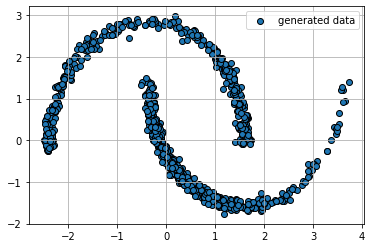

In [ ]:
plt.scatter(sample[:,0],sample[:,1], edgecolor='black', label="generated data")
plt.grid();
plt.legend();

### Траектории с течением времени

Давайте вместе с генерацией запустим процесс и посмотрим, как структура данных меняется с течением времени.

In [ ]:
model.eval()
traj = []
sample = torch.randn(1024, 2) # sampling from noise
timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t,  1024)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if t[0].item() % 5 == 0:
        traj.append(sample.cpu())

100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


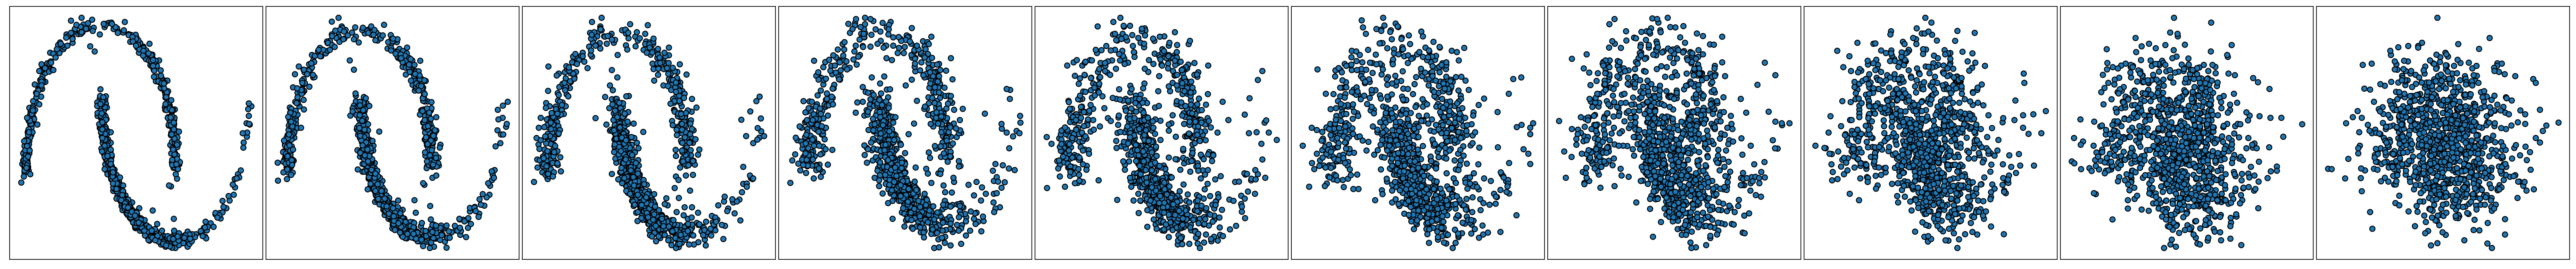

In [ ]:
fig,ax = plt.subplots(1,10,figsize=(40,4),dpi=200)
for idx in range(10):
    ax[idx].scatter(traj[9-idx][:,0],traj[9-idx][:,1],edgecolor='black')
    ax[idx].set_xticks([]);ax[idx].set_yticks([])
    ax[idx].grid();
fig.tight_layout(pad=0.01)

### Полезные материалы

paper_1 - https://arxiv.org/pdf/2006.11239.pdf (дискретная диффузионная модель)

paper_2 - https://arxiv.org/pdf/1503.03585.pdf (первая статья по диффузионным моделям (дискретный случай))

paper_3 - https://arxiv.org/pdf/2011.13456.pdf (статья про диффузионные модели с непрерывным временем)

book_1 - https://www.cmor-faculty.rice.edu/~cox/stoch/SDE.course.pdf (теория стохастических дифференциальных уравнений)

book_2  - https://link.springer.com/book/10.1007/978-1-4939-1323-7 (теория стохастических дифференциальных уравнений)

# Итоги

- Поняли, что иерархические модели VAE лучше стандартных за счет большего числа латентных пространств.
- Если много раз применить детерминированный определенный переход, то любые данные деградируют в шум (теорема 1).
- В соответствии с пунктом выше строим такой прямой процесс, определяемый переходной вероятностью $q(x_{t}|x_{t-1})$.
- На основе прямого процесса, за счет минимизации дивергенции в каждый момент времени, обучаем обратный переходный процесс $p(x_{t-1}|x_{t})$.
- При помощи $p(x_{t-1}|x_{t})$ генерируем картинки из шума.

